In [5]:
!unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Streaming output truncated to the last 5000 lines.
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-N

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

In [4]:
batch_size = 32
img_height = 150
img_width = 150

In [6]:
data_dir="C:\\Users\\datma003\\Desktop\\projects1\\Kidney Stone Detection\\Kidney Stone Detection\\Dataset\\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
train=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.1,
                                                subset='training',seed=123)
val=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.2,
                                                subset='validation',seed=123)

Found 12446 files belonging to 4 classes.
Using 11202 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [8]:
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))
label_to_class_name

{0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

In [10]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


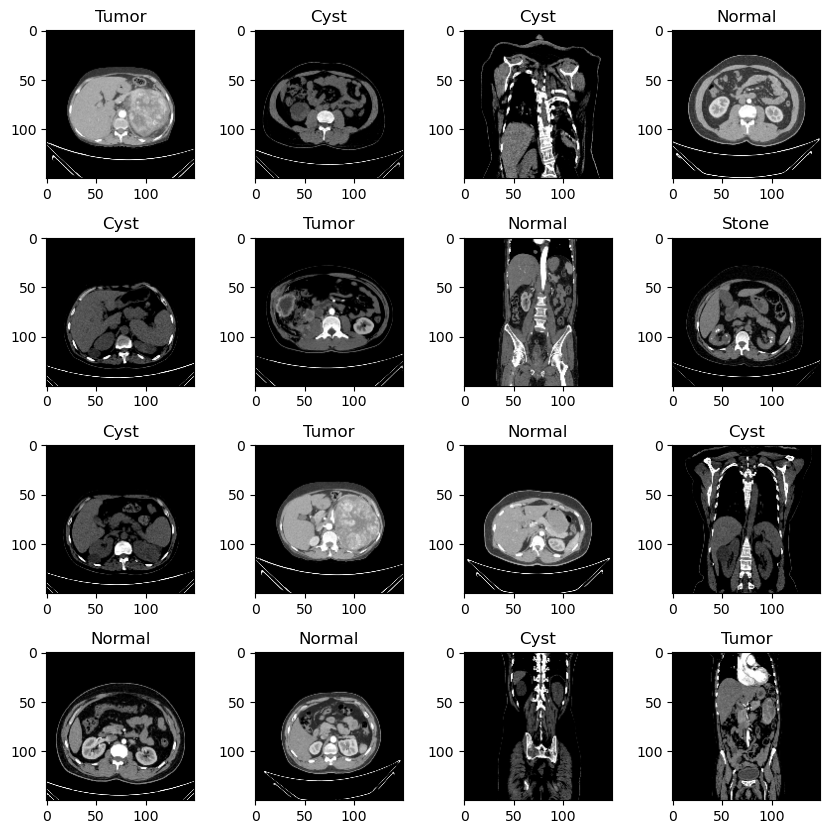

In [12]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

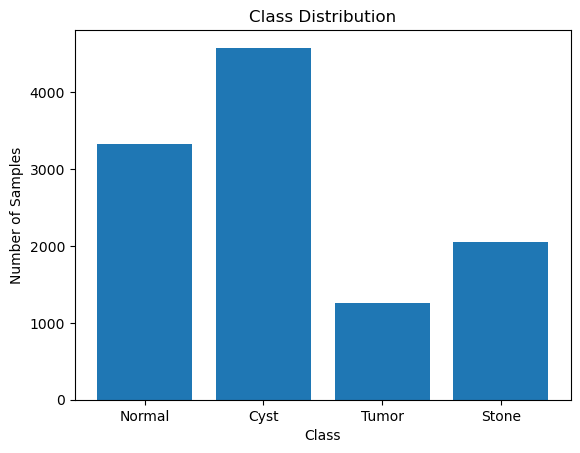

In [14]:
# Manually specify class names based on your dataset structure or labels
class_names = ['Normal', 'Cyst', 'Tumor', 'Stone']

# Initialize counts for each class
num_classes = len(class_names)
counts = np.zeros(num_classes, dtype=int)

# Count samples per class
for images, labels in train:
    label_indices = labels.numpy()
    for label_index in label_indices:
        counts[label_index] += 1

# Plotting the class distribution
plt.bar(class_names, counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

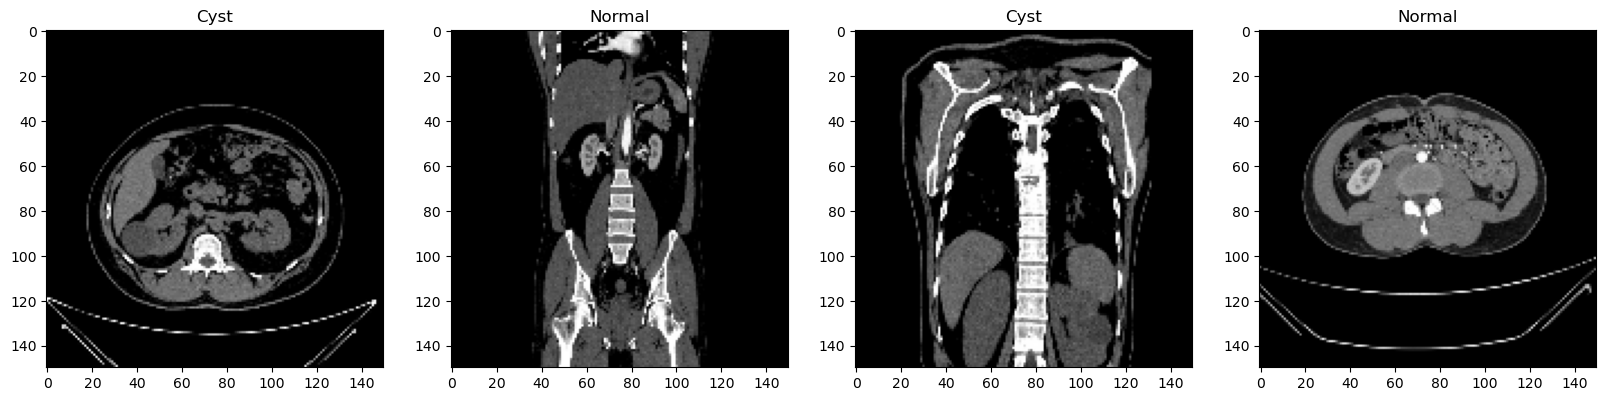

In [16]:
# Display sample images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for i, (images, labels) in enumerate(train.take(1)):
    for j in range(4):
        ax[j].imshow(images[j].numpy().astype("uint8"))
        ax[j].set_title(label_to_class_name[labels[j].numpy()])
plt.show()

In [18]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [20]:
# Normalize images
normalization_layer = layers.Rescaling(1./255)
normalized_train = train.map(lambda x, y: (normalization_layer(x), y))
normalized_val = val.map(lambda x, y: (normalization_layer(x), y))

In [22]:
# Initialize variables to accumulate mean and std
mean = 0.0
std = 0.0
num_samples = 0

# Iterate through the dataset to compute mean and std
for images, labels in train:
    batch_samples = images.shape[0]  # number of images in the batch
    images = images.numpy()  # convert images tensor to numpy array
    mean += np.mean(images, axis=(0, 1, 2)) * batch_samples
    std += np.std(images, axis=(0, 1, 2)) * batch_samples
    num_samples += batch_samples

# Calculate final mean and std
mean /= num_samples
std /= num_samples

print(f"Mean pixel value across dataset: {mean}")
print(f"Std deviation of pixel values across dataset: {std}")

Mean pixel value across dataset: [36.659496 36.659496 36.659496]
Std deviation of pixel values across dataset: [60.94213 60.94213 60.94213]


In [23]:
train=train.map(lambda x,y:(x/255,y))
val=val.map(lambda x,y:(x/255,y))

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
epochs=15
history = model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15


C:\Users\datma003\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 225ms/step - accuracy: 0.8330 - loss: 0.4749 - val_accuracy: 1.0000 - val_loss: 5.9114e-04
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - accuracy: 1.0000 - loss: 3.8258e-04 - val_accuracy: 1.0000 - val_loss: 8.7500e-05
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 64s 183ms/step - accuracy: 1.0000 - loss: 6.0744e-05 - val_accuracy: 1.0000 - val_loss: 4.7180e-05
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 185ms/step - accuracy: 1.0000 - loss: 3.1696e-05 - val_accuracy: 1.0000 - val_loss: 3.0560e-05
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 188ms/step - accuracy: 1.0000 - loss: 1.9181e-05 - val_accuracy: 1.0000 - val_loss: 1.9829e-05
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 196ms/step - accuracy: 1.0000 - loss: 1.1346e-05 - val_accuracy: 1.0000 - val_loss: 1.2640e-05
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - accuracy: 1.0000 - loss: 6.5873e-06 - val_accuracy: 1.0000 - val_loss: 8.4383e-06
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 71

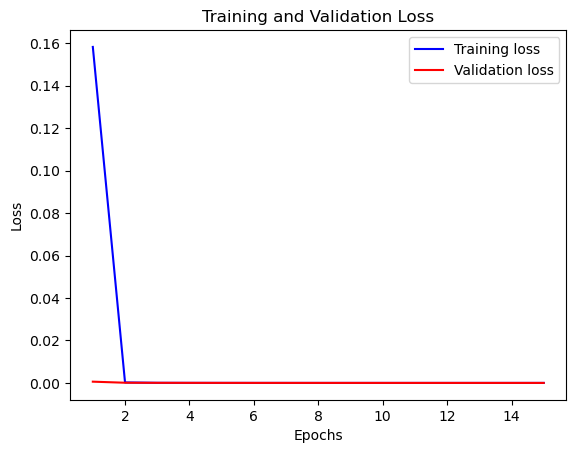

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

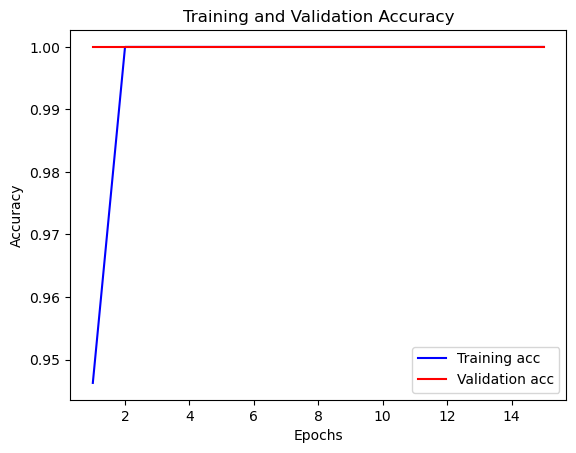

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

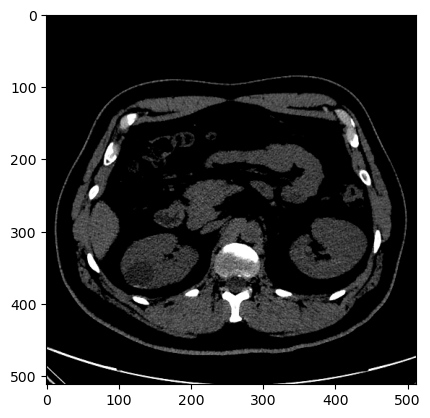

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


'Cyst'

In [36]:
img = cv2.imread(r"C:\Users\datma003\Desktop\projects1\Kidney Stone Detection\Kidney Stone Detection\Dataset\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Cyst\Cyst- (14).jpg")
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

In [37]:
VGG_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(150,150,3),
                   pooling='max',classes=4,
                   weights='imagenet')


VGG_model.add(pretrained_model)
VGG_model.add(Flatten())
VGG_model.add(Dense(512, activation='relu'))
VGG_model.add(BatchNormalization())  # Batch Normalization layer
VGG_model.add(Dropout(0.5))

VGG_model.add(Dense(4, activation='softmax'))
pretrained_model.trainable=False

In [38]:
VGG_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
VGG_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,981,444 (57.15 MB)

 Trainable params: 265,732 (1.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [39]:
epochs=15
history = VGG_model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1106s 3s/step - accuracy: 0.7136 - loss: 0.7847 - val_accuracy: 0.8586 - val_loss: 0.3349
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1077s 3s/step - accuracy: 0.9045 - loss: 0.2693 - val_accuracy: 0.9225 - val_loss: 0.2161
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1041s 3s/step - accuracy: 0.9292 - loss: 0.1974 - val_accuracy: 0.9514 - val_loss: 0.1342
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1218s 3s/step - accuracy: 0.9466 - loss: 0.1516 - val_accuracy: 0.9462 - val_loss: 0.1479
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1218s 3s/step - accuracy: 0.9505 - loss: 0.1357 - val_accuracy: 0.9526 - val_loss: 0.1309
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1261s 4s/step - accuracy: 0.9556 - loss: 0.1214 - val_accuracy: 0.9204 - val_loss: 0.2002
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1264s 4s/step - accuracy: 0.9649 - loss: 0.1001 - val_accuracy: 0.9405 - val_loss: 0.1580
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1281s 4s/step - accuracy: 0.9631 - loss: 0.1021 - 

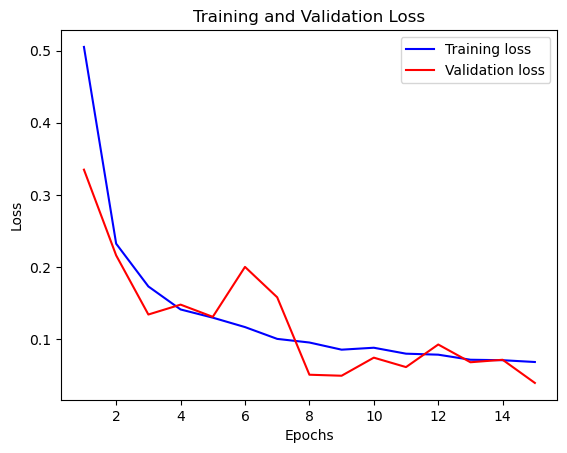

In [40]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

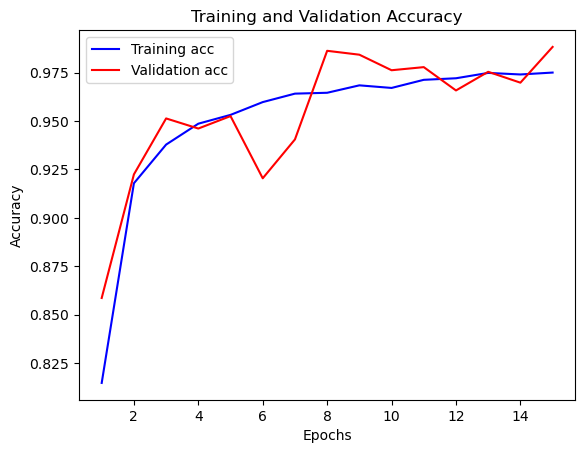

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

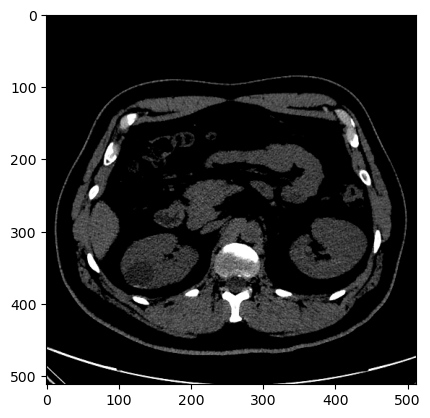

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


'Cyst'

In [42]:
img = cv2.imread(r"C:\Users\datma003\Desktop\projects1\Kidney Stone Detection\Kidney Stone Detection\Dataset\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Cyst\Cyst- (14).jpg")
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = VGG_model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

In [43]:
mobile_net = Sequential()

pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(150,150,3),
                   pooling='max',classes=4,
                   weights='imagenet')


mobile_net.add(pretrained_model)
mobile_net.add(Flatten())
mobile_net.add(Dense(512, activation='relu'))
mobile_net.add(BatchNormalization())  # Batch Normalization layer
mobile_net.add(Dropout(0.5))

mobile_net.add(Dense(4, activation='softmax'))
pretrained_model.trainable=False

C:\Users\datma003\AppData\Local\Temp\ipykernel_6856\3112877574.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,


In [44]:
mobile_net.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
mobile_net.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,917,956 (11.13 MB)

 Trainable params: 658,948 (2.51 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [45]:
epochs=15
history = mobile_net.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 133s 356ms/step - accuracy: 0.7657 - loss: 0.6894 - val_accuracy: 0.9393 - val_loss: 0.1881
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 128s 365ms/step - accuracy: 0.9499 - loss: 0.1480 - val_accuracy: 0.9871 - val_loss: 0.0526
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 120s 341ms/step - accuracy: 0.9674 - loss: 0.0968 - val_accuracy: 0.9602 - val_loss: 0.1087
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 120s 343ms/step - accuracy: 0.9767 - loss: 0.0768 - val_accuracy: 0.9843 - val_loss: 0.0439
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 117s 333ms/step - accuracy: 0.9827 - loss: 0.0566 - val_accuracy: 0.9920 - val_loss: 0.0320
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 120s 341ms/step - accuracy: 0.9864 - loss: 0.0455 - val_accuracy: 0.9743 - val_loss: 0.0731
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 119s 340ms/step - accuracy: 0.9827 - loss: 0.0533 - val_accuracy: 0.9948 - val_loss: 0.0238
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 120s 343ms/step - accuracy: 0.9905 -

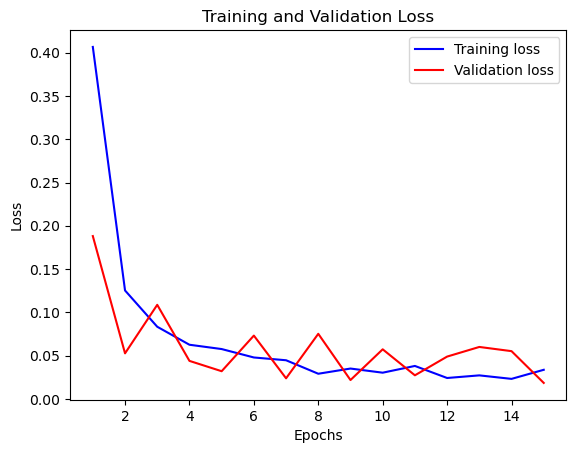

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

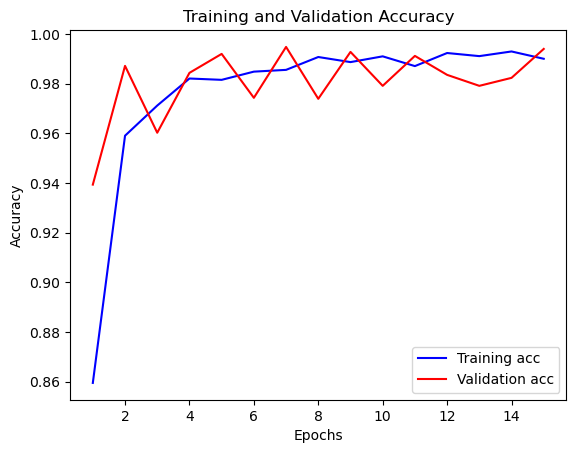

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

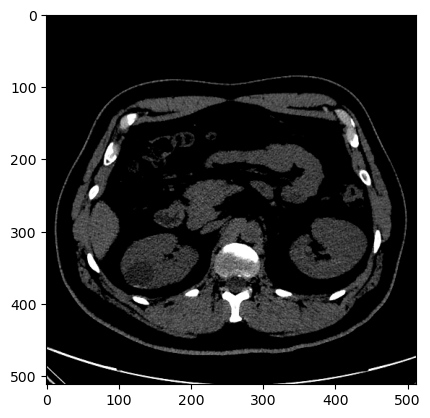

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'Cyst'

In [48]:
img = cv2.imread(r"C:\Users\datma003\Desktop\projects1\Kidney Stone Detection\Kidney Stone Detection\Dataset\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Cyst\Cyst- (14).jpg")
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = mobile_net.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

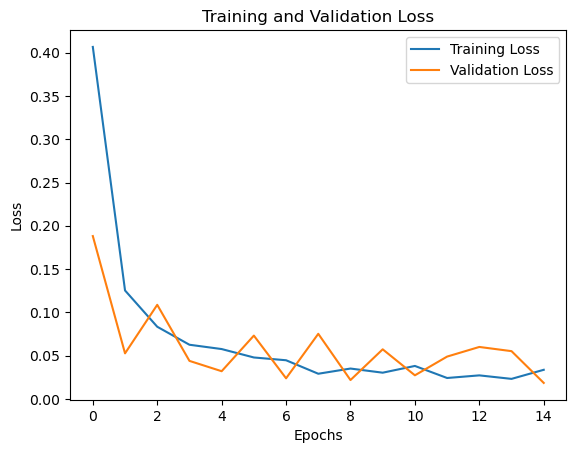

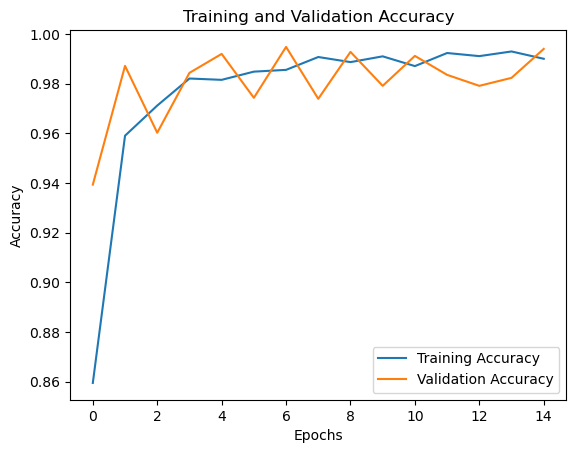

In [49]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [57]:
# Store class names for reporting
from sklearn.metrics import *
class_names = list(label_to_class_name.values())

# Function to predict classes for the validation set
def predict_classes(model, val_dataset):
    y_pred = []
    y_true = []

    for images, labels in val_dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())

    return np.array(y_true), np.array(y_pred)

# Get true and predicted classes
y_true, y_pred = predict_classes(model, val)
# Replace `model` with `VGG_model` or `mobile_net` to evaluate other models

# Calculate classification metrics
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━

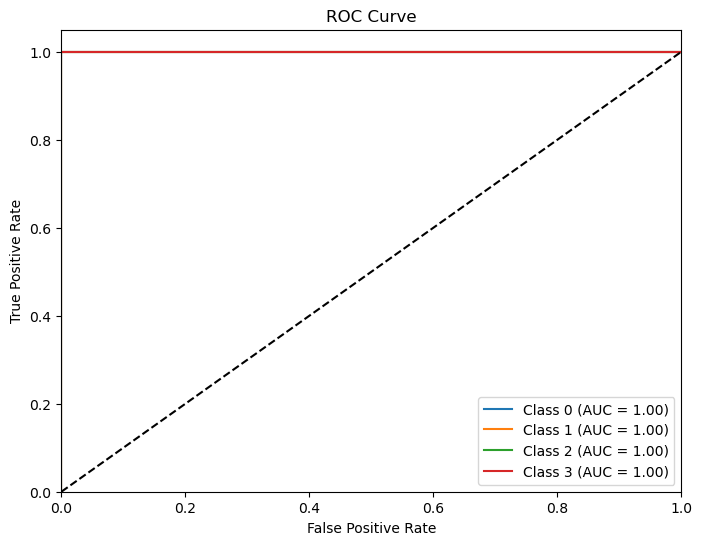

In [59]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

# Function to calculate ROC AUC for each class
def calculate_roc_auc(model, val_dataset):
    y_true = []
    y_score = []

    for images, labels in val_dataset:
        predictions = model.predict(images)
        y_true.extend(label_binarize(labels.numpy(), classes=np.arange(4)))
        y_score.extend(predictions)

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):  # 4 is the number of classes
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

# Calculate ROC AUC for the model
fpr, tpr, roc_auc = calculate_roc_auc(model, val)

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [61]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Compute precision for each class
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
print('Precision:')
print(precision)

Confusion Matrix:
[[ 737    0    0    0]
 [   0 1001    0    0]
 [   0    0  280    0]
 [   0    0    0  471]]
Precision:
[1. 1. 1. 1.]


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_284              │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,855,972 (87.19 MB)

 Trainable params: 1,052,164 (4.01 MB)

 Non-trainable params: 21,803,808 (83.17 MB)

Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 181s 481ms/step - accuracy: 0.7334 - loss: 0.7903 - val_accuracy: 0.9434 - val_loss: 0.1748
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 183s 523ms/step - accuracy: 0.9312 - loss: 0.1963 - val_accuracy: 0.8827 - val_loss: 0.2998
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 195s 555ms/step - accuracy: 0.9505 - loss: 0.1395 - val_accuracy: 0.9743 - val_loss: 0.0854
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 203s 579ms/step - accuracy: 0.9627 - loss: 0.1128 - val_accuracy: 0.9799 - val_loss: 0.0639
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 217s 618ms/step - accuracy: 0.9688 - loss: 0.0987 - val_accuracy: 0.9827 - val_loss: 0.0611
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 237s 676ms/step - accuracy: 0.9728 - loss: 0.0873 - val_accuracy: 0.9634 - val_loss: 0.1072
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 235s 669ms/step - accuracy: 0.9726 - loss: 0.0834 - val_accuracy: 0.9811 - val_loss: 0.0647
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 214s 610ms/step - accuracy: 0.9768 -

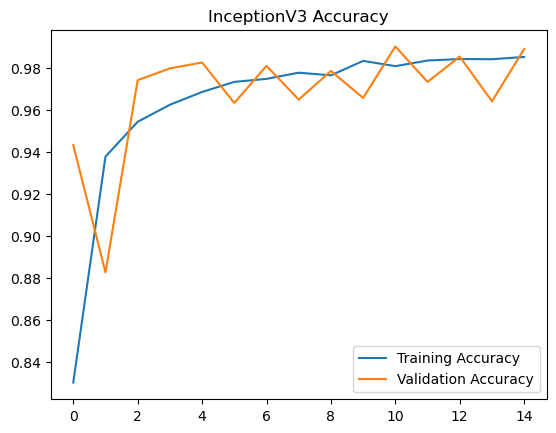

In [67]:
# InceptionV3
from tensorflow.keras.applications import InceptionV3

inception_model = Sequential()

pretrained_model = InceptionV3(include_top=False, 
                               input_shape=(150, 150, 3), 
                               pooling='max', 
                               classes=4, 
                               weights='imagenet')

inception_model.add(pretrained_model)
inception_model.add(Flatten())
inception_model.add(Dense(512, activation='relu'))
inception_model.add(BatchNormalization())  # Batch Normalization layer
inception_model.add(Dropout(0.5))

inception_model.add(Dense(4, activation='softmax'))
pretrained_model.trainable = False

inception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
inception_model.summary()

# Training InceptionV3
epochs = 15
history_inception = inception_model.fit(
    train,
    validation_data=val,
    epochs=epochs
)

# Results
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.title('InceptionV3 Accuracy')
plt.legend()
plt.show()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_285              │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,709,543 (17.97 MB)

 Trainable params: 658,948 (2.51 MB)

 Non-trainable params: 4,050,595 (15.45 MB)

Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 175s 454ms/step - accuracy: 0.3355 - loss: 1.5216 - val_accuracy: 0.4022 - val_loss: 1.3467
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 154s 439ms/step - accuracy: 0.3775 - loss: 1.3477 - val_accuracy: 0.2961 - val_loss: 1.3215
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 159s 454ms/step - accuracy: 0.3843 - loss: 1.3188 - val_accuracy: 0.4022 - val_loss: 1.3000
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 156s 444ms/step - accuracy: 0.3865 - loss: 1.3032 - val_accuracy: 0.4022 - val_loss: 1.2892
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 161s 459ms/step - accuracy: 0.4046 - loss: 1.2915 - val_accuracy: 0.4022 - val_loss: 1.3115
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 159s 454ms/step - accuracy: 0.4047 - loss: 1.2919 - val_accuracy: 0.4022 - val_loss: 1.2900
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 161s 458ms/step - accuracy: 0.4042 - loss: 1.2913 - val_accuracy: 0.4022 - val_loss: 1.3097
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 157s 448ms/step - accuracy: 0.3989 -

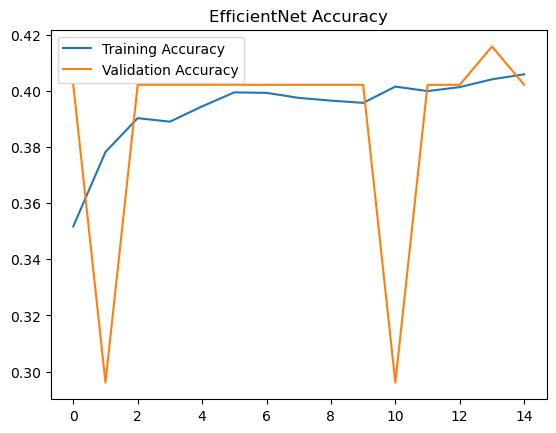

In [68]:
# EfficientNet
from tensorflow.keras.applications import EfficientNetB0

efficient_model = Sequential()

pretrained_model = EfficientNetB0(include_top=False, 
                                  input_shape=(150, 150, 3), 
                                  pooling='max', 
                                  classes=4, 
                                  weights='imagenet')

efficient_model.add(pretrained_model)
efficient_model.add(Flatten())
efficient_model.add(Dense(512, activation='relu'))
efficient_model.add(BatchNormalization())  # Batch Normalization layer
efficient_model.add(Dropout(0.5))

efficient_model.add(Dense(4, activation='softmax'))
pretrained_model.trainable = False

efficient_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
efficient_model.summary()

# Training EfficientNet
history_efficient = efficient_model.fit(
    train,
    validation_data=val,
    epochs=epochs
)

# Results
plt.plot(history_efficient.history['accuracy'], label='Training Accuracy')
plt.plot(history_efficient.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNet Accuracy')
plt.legend()
plt.show()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 1024)                │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_286              │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,566,404 (28.86 MB)

 Trainable params: 527,876 (2.01 MB)

 Non-trainable params: 7,038,528 (26.85 MB)

Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.7399 - loss: 0.7479 - val_accuracy: 0.8779 - val_loss: 0.3162
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.9168 - loss: 0.2312 - val_accuracy: 0.9542 - val_loss: 0.1449
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9417 - loss: 0.1717 - val_accuracy: 0.9148 - val_loss: 0.2392
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9530 - loss: 0.1356 - val_accuracy: 0.9614 - val_loss: 0.1140
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - accuracy: 0.9535 - loss: 0.1312 - val_accuracy: 0.9558 - val_loss: 0.1219
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.9575 - loss: 0.1195 - val_accuracy: 0.9691 - val_loss: 0.0971
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.9619 - loss: 0.1087 - val_accuracy: 0.9654 - val_loss: 0.1021
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.9663 - loss: 0.1001 - val_accu

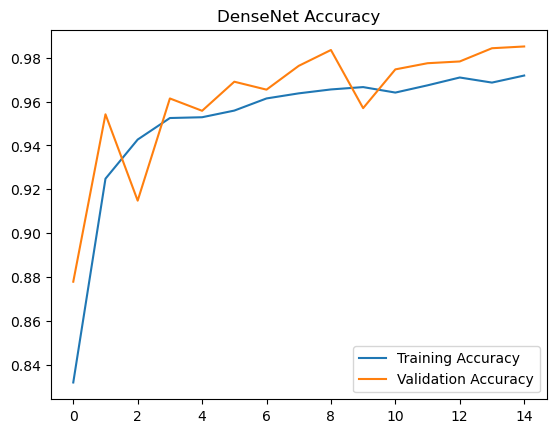

In [69]:
# DenseNet
from tensorflow.keras.applications import DenseNet121

densenet_model = Sequential()

pretrained_model = DenseNet121(include_top=False, 
                               input_shape=(150, 150, 3), 
                               pooling='max', 
                               classes=4, 
                               weights='imagenet')

densenet_model.add(pretrained_model)
densenet_model.add(Flatten())
densenet_model.add(Dense(512, activation='relu'))
densenet_model.add(BatchNormalization())  # Batch Normalization layer
densenet_model.add(Dropout(0.5))

densenet_model.add(Dense(4, activation='softmax'))
pretrained_model.trainable = False

densenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
densenet_model.summary()

# Training DenseNet
history_densenet = densenet_model.fit(
    train,
    validation_data=val,
    epochs=epochs
)

# Results
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('DenseNet Accuracy')
plt.legend()
plt.show()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)          │ (None, 2048)                │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,566,715 (112.79 MB)

 Trainable params: 1,052,164 (4.01 MB)

 Non-trainable params: 28,514,551 (108.77 MB)

Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1196s 3s/step - accuracy: 0.3664 - loss: 1.5129 - val_accuracy: 0.4126 - val_loss: 1.6686
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1117s 3s/step - accuracy: 0.4251 - loss: 1.3273 - val_accuracy: 0.4873 - val_loss: 1.3294
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 668s 2s/step - accuracy: 0.4446 - loss: 1.2791 - val_accuracy: 0.1892 - val_loss: 5.3375
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 653s 2s/step - accuracy: 0.4471 - loss: 1.2591 - val_accuracy: 0.2961 - val_loss: 1.3737
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 648s 2s/step - accuracy: 0.4553 - loss: 1.2569 - val_accuracy: 0.2961 - val_loss: 1.3378
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 700s 2s/step - accuracy: 0.4609 - loss: 1.2458 - val_accuracy: 0.2961 - val_loss: 2.6232
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - accuracy: 0.4420 - loss: 1.2604 - val_accuracy: 0.4046 - val_loss: 2.7725
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.4480 - loss: 1.2556 - val_ac

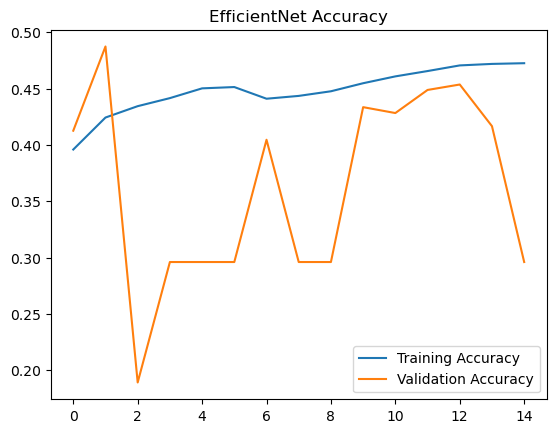

In [30]:
# EfficientNet
from tensorflow.keras.applications import EfficientNetB5

efficient_model = Sequential()

pretrained_model = EfficientNetB5(include_top=False, 
                                  input_shape=(150, 150, 3), 
                                  pooling='max', 
                                  classes=4, 
                                  weights='imagenet')

efficient_model.add(pretrained_model)
efficient_model.add(Flatten())
efficient_model.add(Dense(512, activation='relu'))
efficient_model.add(BatchNormalization())  # Batch Normalization layer
efficient_model.add(Dropout(0.5))

efficient_model.add(Dense(4, activation='softmax'))
pretrained_model.trainable = False

efficient_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
efficient_model.summary()

# Training EfficientNet
history_efficient = efficient_model.fit(
    train,
    validation_data=val,
    epochs=15
)

# Results
plt.plot(history_efficient.history['accuracy'], label='Training Accuracy')
plt.plot(history_efficient.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNet Accuracy')
plt.legend()
plt.show()
